## Ex-04

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

### Task 1

#### 1.1

In [2]:
def simulate_sir_simple(lam, mu, I0, T, N):
    X = [] # observations
    C = [] # states

    I = I0 # number of infected individuals
    R = 0 # number of recovered individuals
    S = N - I - R # number of susceptible individuals

    for t in range(T):
        C.append((S, I, R))

        dS = -lam * S * I / N
        dI = lam * S * I / N - (mu * I)
        dR = mu * I

        # for T+1
        S_next = S + dS
        I_next = I + dI
        R_next = R + dR

        dS = S - S_next
        dR = R_next - R

        X.append((dS, dR))

        S,I,R = S_next, I_next, R_next
    
    return np.array(X), np.array(C)

#### 1.2

In [3]:
def explore_prior(N, T, lam_list, mu_list, I0_list):
    fig, axes = plt.subplots(len(lam_list), len(mu_list), figsize=(15, 15), sharex=True, sharey=True)
    for i, lam in enumerate(lam_list):
        for j, mu in enumerate(mu_list):
            for I0 in I0_list:
                _, states = simulate_sir_simple(lam, mu, I0, T, N)
                
                S,I,R = zip(*states)
                S, I, R = np.array(S), np.array(I), np.array(R)

                ax=axes[i, j]
                ax.plot(range(T), S, label=f'S(t), I0={I0}')
                ax.plot(range(T), I, label=f'I(t), I0={I0}')
                ax.plot(range(T), R, label=f'R(t), I0={I0}')
                ax.set_title(f'λ={lam}, μ={mu}')
                ax.set_xlabel('days')
                ax.set_ylabel('population')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(I0_list))
    plt.tight_layout()
    plt.show()

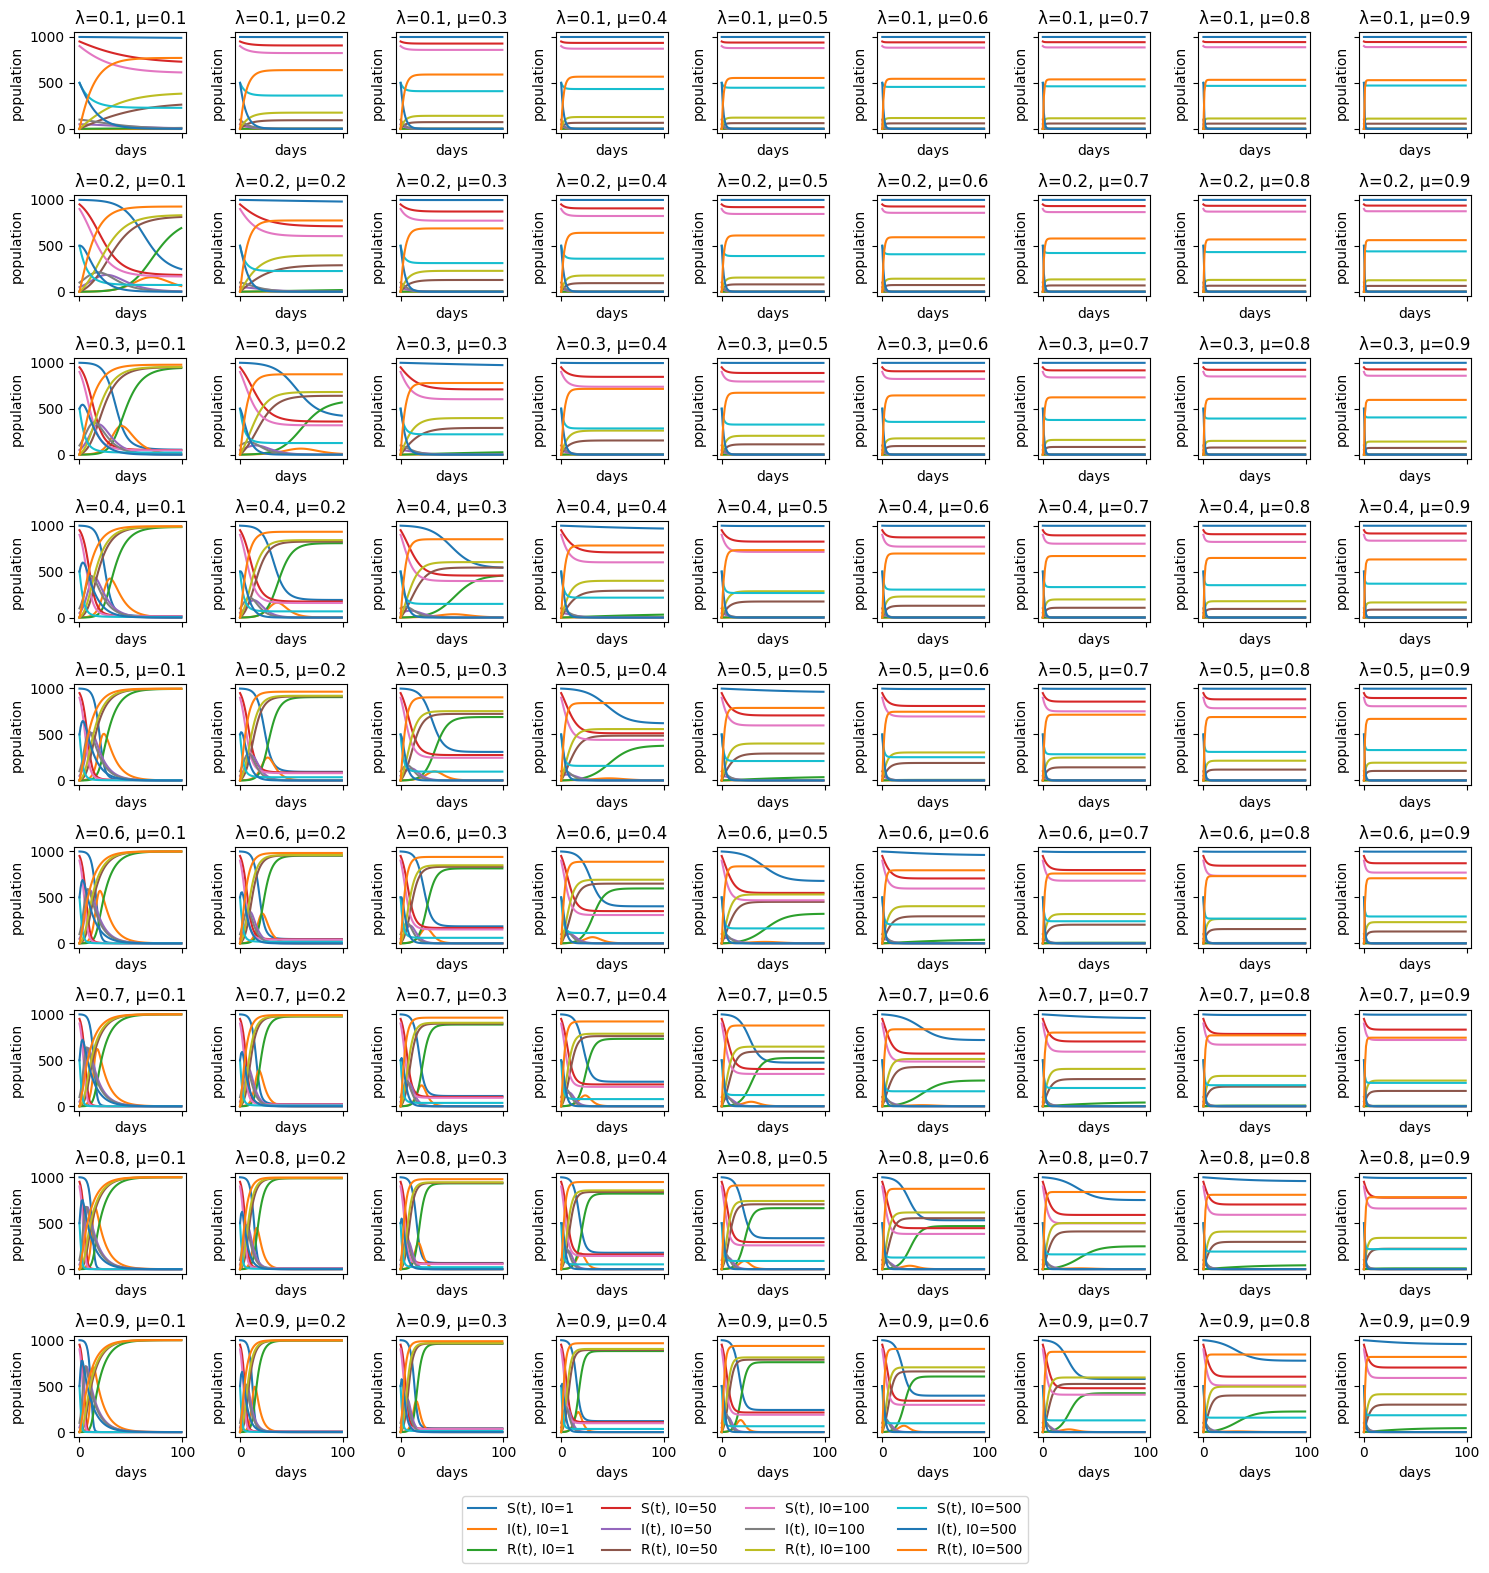

In [4]:
N = 1000
T = 100

# hyperparameters
lam_list = np.round(np.linspace(0.1, 0.9, 9),1)
mu_list = np.round(np.linspace(0.1, 0.9, 9),1)
I0_list =  [1, 50, 100, 500]

explore_prior(N, T, lam_list, mu_list, I0_list)



With range
* lambda = [0.2, 0.9]
* mu = [0.1, 0.7]
* I_0 = [1, 100]
  
the most diverse dynamics are observed.

#### 1.3

In [5]:
def generate_sir_data(num_samples, T, N):
    data = []
    target = []

    for _ in range(num_samples):
        lam = np.random.uniform(0.2, 0.9)
        mu = np.random.uniform(0.1, 0.7)
        I0 = np.random.randint(1,100)

        X, _ = simulate_sir_simple(lam, mu, I0, T, N)

        data.append(X.flatten())
        target.append([lam, mu, I0])

    return np.array(data), np.array(target)

class SIRDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]
    
class SIRModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SIRModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [6]:
def train_model(model, criterion, optimizer, data_loader, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()
            
            output = model(x_batch)
            
            loss = criterion(output, y_batch)
            loss.backward()
            
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss/len(data_loader))
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}')
    return losses

def test_model(model, dataloader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            outputs = model(x_batch)

            preds.append(np.array(outputs))
            targets.append(np.array(y_batch))
    
    return np.vstack(preds), np.vstack(targets)

Training mode ...
Epoch 1/50, Loss: 227.4542
Epoch 6/50, Loss: 9.9749
Epoch 11/50, Loss: 1.5618
Epoch 16/50, Loss: 0.3676
Epoch 21/50, Loss: 0.3637
Epoch 26/50, Loss: 0.2144
Epoch 31/50, Loss: 0.1780
Epoch 36/50, Loss: 0.8025
Epoch 41/50, Loss: 0.2577
Epoch 46/50, Loss: 0.5175


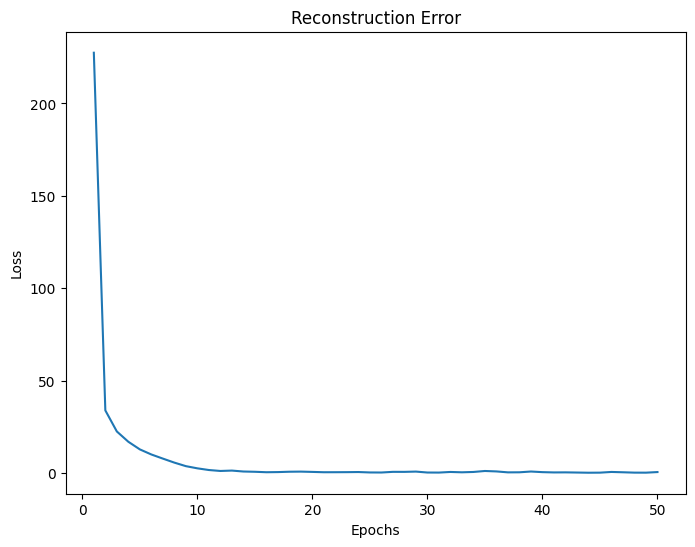

Test mode ...


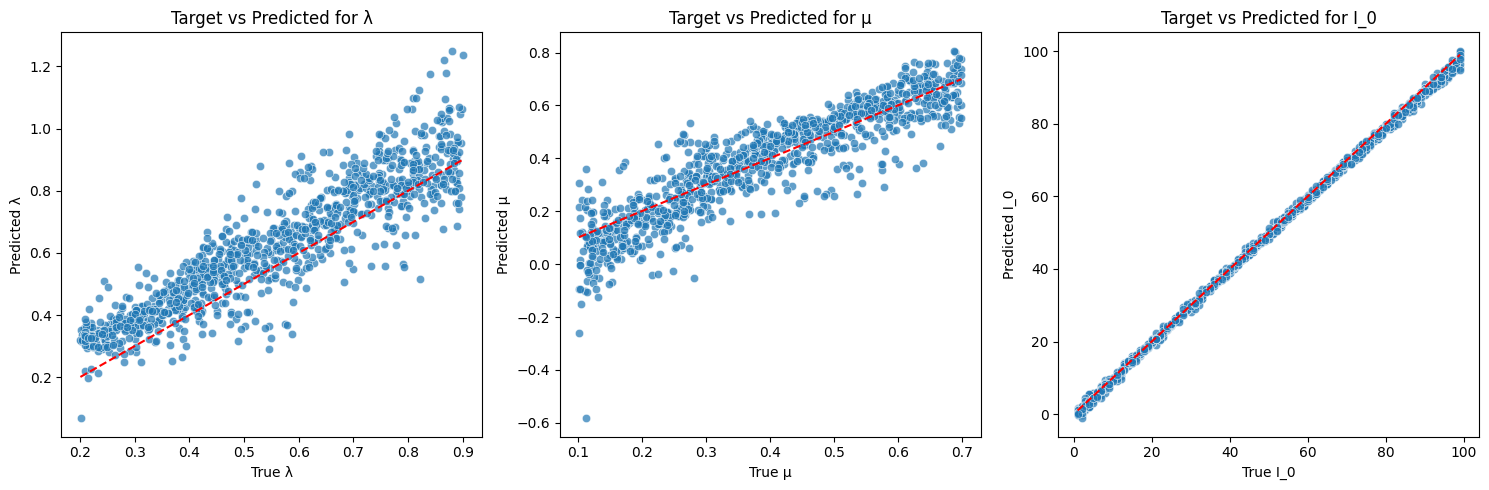

In [7]:
# hyperparameters
N = 1000
T = 100
num_samples = 5000
test_samples = 1000
input_size = T*2 # flattened SIR
hidden_size = 128
output_size = 3 # [lam, mu, I0]
batch_size = 64
lr = 0.001
epochs = 50

# generate data
x_train, y_train = generate_sir_data(num_samples, T, N)
x_test, y_test = generate_sir_data(num_samples=test_samples, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initialize model
model = SIRModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train model
print('Training mode ...')
train_loss = train_model(model, criterion, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

#test model
print('Test mode ...')
preds, targets = test_model(model, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, param in enumerate(cols):
        sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
        axes[i].plot([target_df[param].min(), target_df[param].max()],
                     [target_df[param].min(), target_df[param].max()],
                     color='red', linestyle='--')
        axes[i].set_xlabel(f'True {param}')
        axes[i].set_ylabel(f'Predicted {param}')
        axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


#### 1.4

In [8]:
# Conditional realNVP components
class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size):
        super(ConditionalCouplingLayer, self).__init__()
        self.split1 = input_size // 2
        self.split2 = input_size - self.split1

        self.subnet = nn.Sequential(
            nn.Linear(self.split1 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * self.split2),
        )

    def forward(self, x, cond):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)

        log_jacob_det = torch.sum(s, dim=-1)

        x2 = torch.exp(s) * x2 + t
        return torch.cat([x1, x2], dim=-1), log_jacob_det


    def reverse(self, x, cond):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)

        x2 = (x2 - t) * torch.exp(-s)
        return torch.cat([x1, x2], dim=-1)

class ConditionalrealNVP(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size, n_layers):
        super(ConditionalrealNVP, self).__init__()
        self.layers = nn.ModuleList([
            ConditionalCouplingLayer(input_size, condition_size, hidden_size) for _ in range(n_layers)
        ])

    def forward(self, x, context):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x, context)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def reverse(self, z, context):
        for layer in reversed(self.layers):
            z = layer.reverse(z, context)
        return z

In [9]:
def train_realNVP(feature_extractor, realNVP, optimizer, data_loader, epochs):
    feature_extractor.train()
    realNVP.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()

            context = feature_extractor(x_batch)
            z, log_det_jacobian = realNVP(y_batch, context)
            
            nll = 0.5 * torch.sum(z**2, dim=1) - log_det_jacobian
            loss = torch.mean(nll)
            loss.backward()
            
            optimizer.step()
            epoch_loss += loss.item()
        
        losses.append(epoch_loss/len(data_loader))

        if epoch % 2 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}')
    
    return np.array(losses)

def test_realNVP(feature_extractor, realNVP, data_loader):
    feature_extractor.eval()
    realNVP.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            context = feature_extractor(x_batch)
            outputs = realNVP.reverse(torch.randn_like(y_batch), context)

            preds.append(np.array(outputs))
            targets.append(np.array(y_batch))
    
    return np.vstack(preds), np.vstack(targets)


Training mode ...
Epoch 1/50, Loss: 43.7763
Epoch 3/50, Loss: 1.3777
Epoch 5/50, Loss: 0.8639
Epoch 7/50, Loss: 0.5978
Epoch 9/50, Loss: 0.3389
Epoch 11/50, Loss: 0.2900
Epoch 13/50, Loss: 0.2156
Epoch 15/50, Loss: 0.2351
Epoch 17/50, Loss: 0.2013
Epoch 19/50, Loss: 0.1395
Epoch 21/50, Loss: 0.2042
Epoch 23/50, Loss: 0.0285
Epoch 25/50, Loss: -0.0149
Epoch 27/50, Loss: 0.1696
Epoch 29/50, Loss: 0.1586
Epoch 31/50, Loss: -0.0646
Epoch 33/50, Loss: 0.4619
Epoch 35/50, Loss: 0.0032
Epoch 37/50, Loss: 0.4385
Epoch 39/50, Loss: 0.3879
Epoch 41/50, Loss: -0.1990
Epoch 43/50, Loss: -0.2836
Epoch 45/50, Loss: -0.2550
Epoch 47/50, Loss: -0.4250
Epoch 49/50, Loss: -0.5067


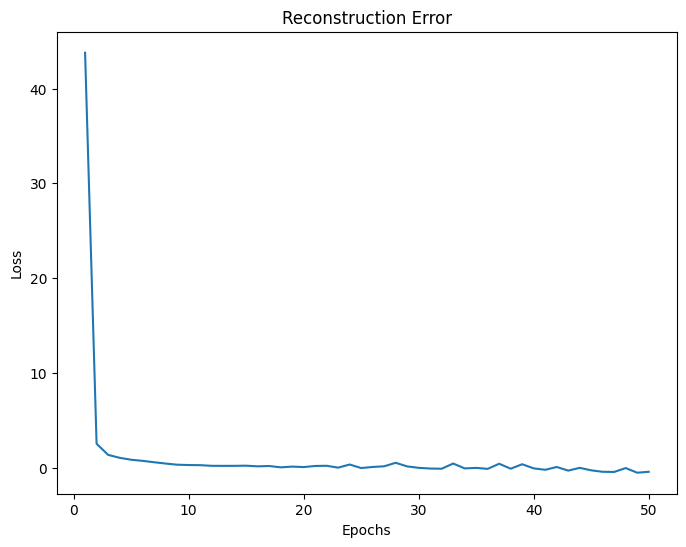

Test mode ...


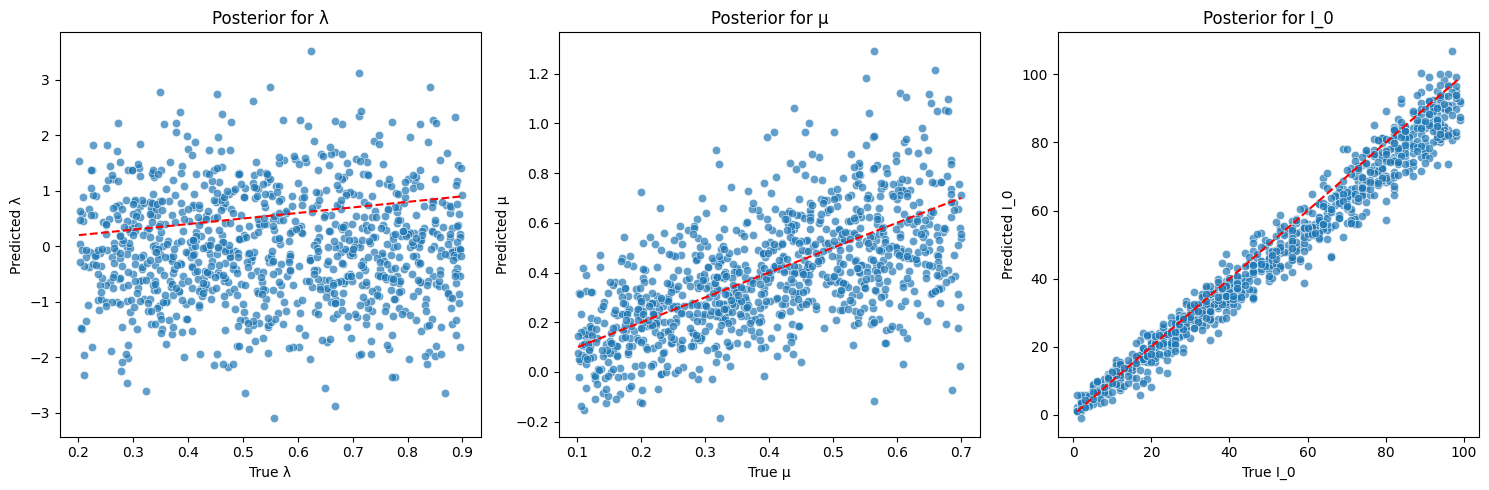

In [10]:
# Hyperparameters
T = 100
N = 1000
num_samples = 5000
test_samples = 1000
input_size = T*2 # Flattened (dS, dR)
hidden_size = 64
batch_size = 64
lr = 0.001
epochs = 50
n_layers=2


# generate data
x_train, y_train = generate_sir_data(num_samples, T, N)
x_test, y_test = generate_sir_data(num_samples=test_samples, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize feature extractor and realNVP
feature_extractor = SIRModel(input_size, hidden_size, hidden_size)
realNVP = ConditionalrealNVP(input_size=3, condition_size=hidden_size, hidden_size=hidden_size, n_layers=n_layers)

# Define optimizer
params = list(feature_extractor.parameters()) + list(realNVP.parameters())
optimizer = optim.Adam(params, lr=lr)

# train model
print('Training mode ...')
train_loss = train_realNVP(feature_extractor, realNVP, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

# test model
print('Test mode ...')
preds, targets = test_realNVP(feature_extractor, realNVP, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Posterior for {param}')
plt.tight_layout()
plt.show()


#### 1.5

In [11]:
def generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds):

    feature_extractor.eval()
    realNVP.eval()

    all_samples = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(next(feature_extractor.parameters()).device)
            context = feature_extractor(x)

            samples = []
            for _ in range(num_preds):
                z = torch.randn((x.size(0), 3), device=context.device)  # Sampling from prior
                sample = realNVP.reverse(z, context)
                samples.append(sample.cpu().numpy())

            all_samples.append(np.stack(samples, axis=0))
            all_targets.append(y.numpy())

    preds = np.concatenate(all_samples, axis=1)  # Shape: (M, len(test_data), num_params)
    targets = np.concatenate(all_targets, axis=0)  # Shape: (len(test_data), num_params)

    return preds, targets

def compute_energy(y_samples, targets):
    
    targets = targets[None, :, :]  # Broadcast for M samples
    energy = -0.5 * np.sum((y_samples - targets) ** 2, axis=-1)  # Gaussian assumption
    return energy

def plot_posterior_distributions(samples):

    params = ['λ', 'μ', 'I_0']

    fig, axes = plt.subplots(2, len(params), figsize=(15, 5))
    for i, param in enumerate(params):
        param_samples = samples[:, :, i].flatten()

        axes[0,i].hist(param_samples, bins=30, density=True, alpha=0.5, label='Posterior Samples')
        axes[0,i].set_title(f'Posterior Histogram - {param}')
        axes[0,i].set_xlabel('Value')
        axes[0,i].set_ylabel('Density')
        axes[0,i].legend()

        # Empirical CDF
        ecdf = np.sort(param_samples)
        axes[1,i].plot(ecdf, np.linspace(0, 1, len(ecdf)), label='Empirical CDF', lw=2)
        axes[1,i].set_title(f'Empirical CDF - {param}')
        axes[1,i].set_xlabel('Value')
        axes[1,i].set_ylabel('Cumulative Probability')
        axes[1,i].legend()

    plt.tight_layout()
    plt.show()

def plot_joint_distribution(samples):

    params = ['λ', 'μ', 'I_0']

    joint_samples = samples.reshape(-1, samples.shape[-1])  # Shape: (M * len(X), num_params)
    df = pd.DataFrame(joint_samples, columns=params)

    sns.pairplot(df, diag_kind='kde', plot_kws={'s': 1, 'alpha':0.5}, corner=True)
    plt.suptitle('Joint Posterior Distribution', y=1)
    plt.show()

Mean Energy Score: -20.1226
Standard Deviation of Energy Scores: 32.3653


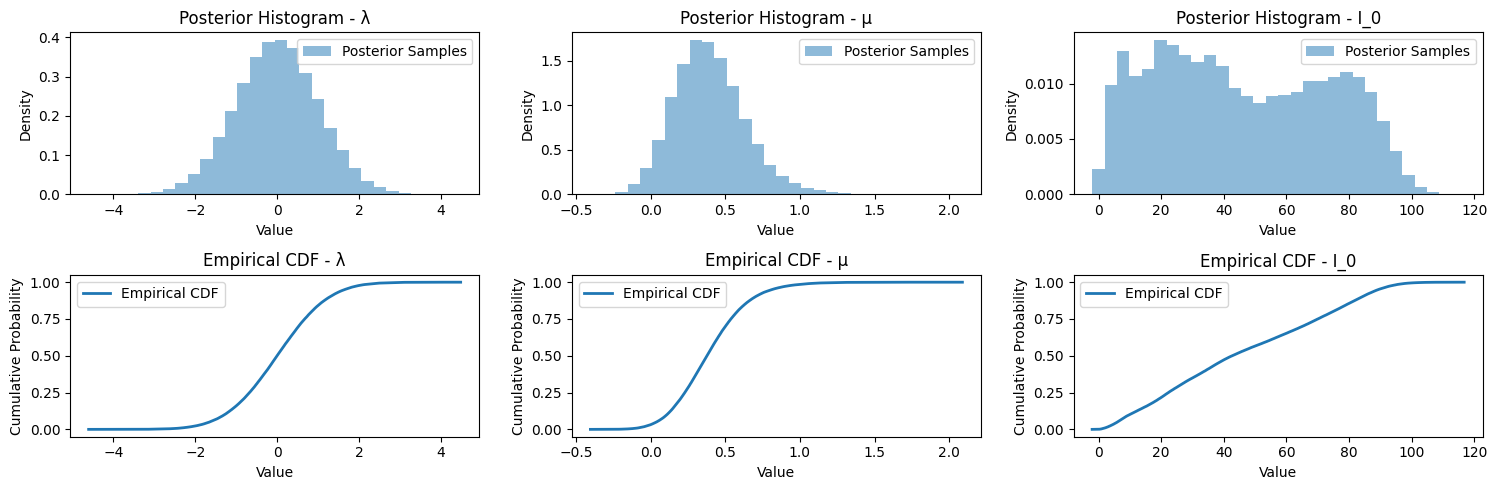

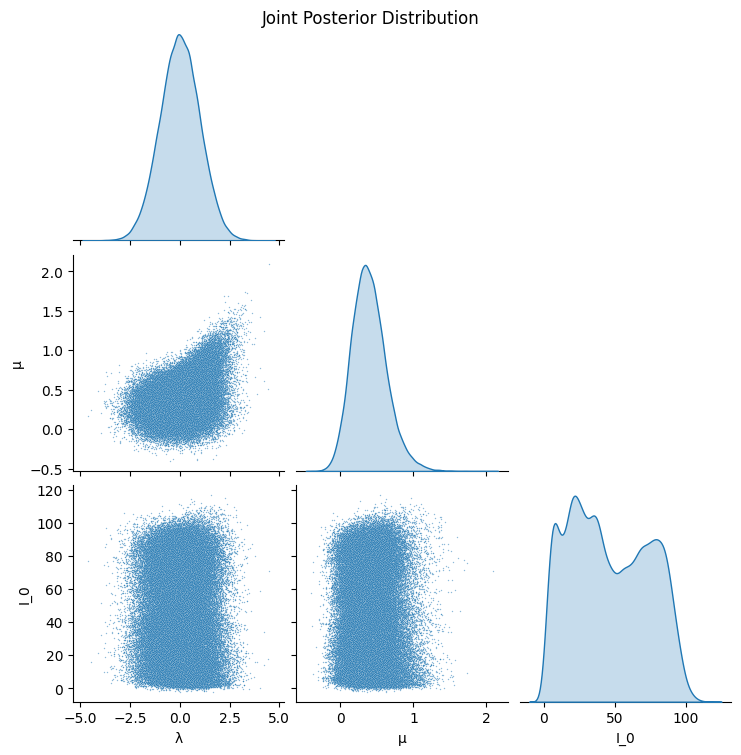

In [12]:
num_preds = 100

preds, targets = generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds)

energy_scores = compute_energy(preds, targets)

# displaying summarized energy scores
print(f'Mean Energy Score: {np.mean(energy_scores):.4f}')
print(f'Standard Deviation of Energy Scores: {np.std(energy_scores):.4f}')

# marginal distributions
plot_posterior_distributions(preds)

# joint distributions
plot_joint_distribution(preds)


### 1.6

In [13]:
def plot_confidence_intervals(resimulated_outcomes, true_simulated_outcomes, coverage):

    lower_bound = np.percentile(resimulated_outcomes, 2.5, axis=0)
    upper_bound = np.percentile(resimulated_outcomes, 97.5, axis=0)
    
    params = ['dS', 'dR']

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    for i, param in enumerate(params):
        axes[i].fill_between(range(len(lower_bound)), lower_bound[:, i], upper_bound[:, i], color='skyblue', alpha=0.5, label='95% CI')
        axes[i].plot(true_simulated_outcomes[:, i], 'o', color='orange', label='True Outcomes')
        axes[i].set_xlabel('samples')
        axes[i].set_ylabel(f'{param}')
        axes[i].legend()
    plt.suptitle(f'Posterior Predictive Calibration with coverage = {coverage}')
    plt.tight_layout()
    plt.show()

In [14]:
def posterior_predictive_calibration(posterior_samples, simulate_sir_simple, true_outcomes, T, N):

    M = posterior_samples.shape[0]

    resimulated_outcomes = []

    # simulate outcomes for predicted samples
    for k in range(M):
        current_outcomes = []
        for lam, mu, I0 in posterior_samples[k]:
            X, _ = simulate_sir_simple(lam, mu, I0, T, N)
            current_outcomes.append(np.sum(X, axis=0))
        resimulated_outcomes.append(np.stack(current_outcomes, axis=0))

    resimulated_outcomes = np.stack(resimulated_outcomes, axis=0)

    # simulate outcomes for true samples
    true_simulated_outcomes = []
    for lam, mu, I0 in true_outcomes:
        X, _ = simulate_sir_simple(lam, mu, I0, T, N)
        true_simulated_outcomes.append(np.sum(X, axis=0))

    true_simulated_outcomes = np.stack(true_simulated_outcomes, axis=0)

    # confidence intervals from predicted simulations
    lower_bound = np.percentile(resimulated_outcomes, 2.5, axis=0)
    upper_bound = np.percentile(resimulated_outcomes, 97.5, axis=0)

    # Check if true simulated outcomes are within confidence intervals
    true_within_interval = np.logical_and(true_simulated_outcomes >= lower_bound, true_simulated_outcomes <= upper_bound)

    # coverage as the proportion of observations within intervals
    coverage = np.mean(np.all(true_within_interval, axis=1))

    plot_confidence_intervals(resimulated_outcomes, true_simulated_outcomes, coverage)
    
    
    return coverage


C:\Users\hp\AppData\Local\Temp\ipykernel_4884\1062177979.py:12: RuntimeWarning: overflow encountered in scalar multiply
  dS = -lam * S * I / N
C:\Users\hp\AppData\Local\Temp\ipykernel_4884\1062177979.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dI = lam * S * I / N - (mu * I)
C:\Users\hp\AppData\Local\Temp\ipykernel_4884\1062177979.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  dS = S - S_next
C:\Users\hp\AppData\Local\Temp\ipykernel_4884\1062177979.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  dR = R_next - R
C:\Users\hp\AppData\Local\Temp\ipykernel_4884\1062177979.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  dI = lam * S * I / N - (mu * I)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), 

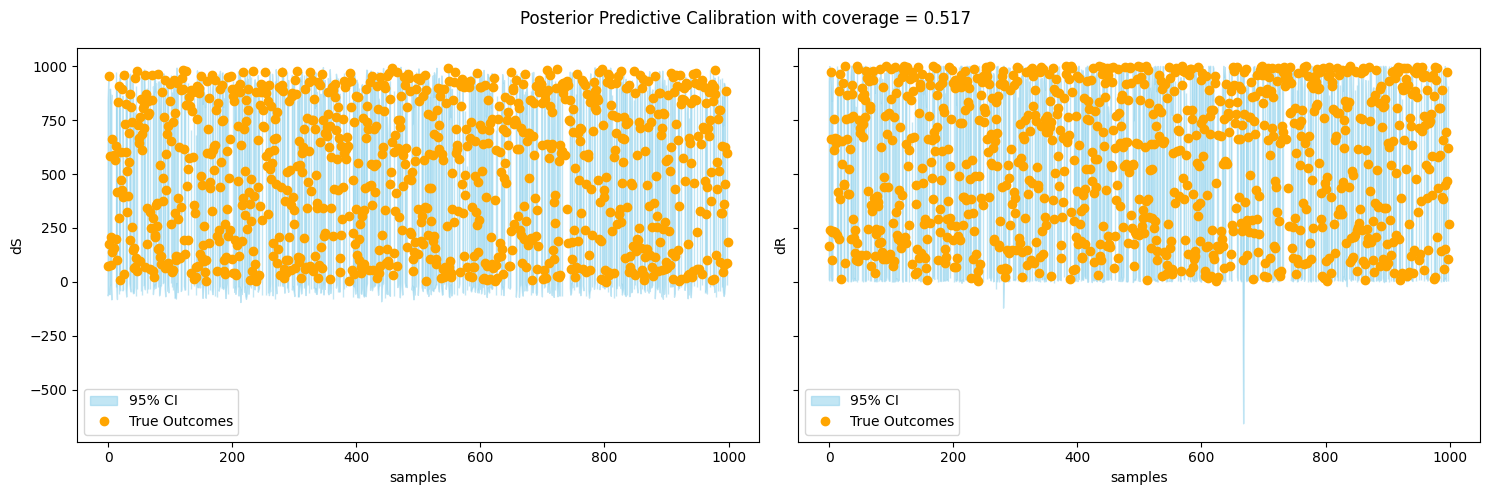

0.517

In [15]:
posterior_predictive_calibration(preds, simulate_sir_simple, y_test, T, N)


### Task 2

#### 2.1

---